In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn
# import visualize
import scipy.stats as stats
# import os, re, fnmatch
# import pathlib, itertools
import time as timelib


## for piprline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler

## for measuring performance
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import make_scorer, precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import roc_curve, auc, f1_score, recall_score

## for model buildig 
import sklearn
from sklearn.svm import SVC
from sklearn.externals import joblib
import pdb; 

HOME_DIR = pathlib.Path.home()
CW_DIR = pathlib.Path.cwd()

## figure/plot size

# FIGW = 16
# FIGH = 12
# FONTSIZE = 6

# plt.rcParams['figure.figsize'] = (FIGW, FIGH)
# plt.rcParams['font.size'] = FONTSIZE

# plt.rcParams['xtick.labelsize'] = FONTSIZE
# plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline

In [45]:
# Pipeline component 1
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        return X[self.attribs]

In [46]:
"""
*** This piece of code has been copied (slightly edited) from a custom module ***
"""
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import explained_variance_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def skillScore(y_true, y_pred, skill='pss'):
    """
    Compute various skill scores
    PARAMS:
        y_true: the true classification label
        y_pred: the classification predicted by the model (must be binary)
        skill: a string used to select a particular skill score to compute
                'pss' | 'hss' | 'bss'
    """
    cmtx = confusion_matrix(y_true, y_pred)
    tn = cmtx[0,0]
    fp = cmtx[0,1]
    fn = cmtx[1,0]
    tp = cmtx[1,1]

    if skill == 'acc': #accuracy
        return float(tp + tn) / (tp + fn + tn + fp)
    if skill == 'pss':
        tpr = float(tp) / (tp + fn)
        fpr = float(fp) / (fp + tn)
        pss = tpr - fpr
        return  [pss, tpr, fpr] 
    if skill == 'hss': #Heidke
        return 2.0 * (tp*tn - fp*fn) / ((tp+fn) * (fn+tn) + (tp+fp) * (fp+tn))
    if skill == 'bss': #Brier Skill Score
        return np.mean((y_true - y_pred) **2)

def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    PARAMS:
        cm: the confusion matrix
        classes: list of unique class labels
        normalize: boolean flag whether to normalize values
        title: figure title
        cmap: colormap scheme
    """
    # View percentages
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_mtx', bbox_inches="tight")

# Generate a color map plot for a confusion matrix
def confusion_mtx_colormap(mtx, xnames, ynames, cbarlabel=""):
    ''' 
    Generate a figure that plots a colormap of a matrix
    PARAMS:
        mtx: matrix of values
        xnames: list of x tick names
        ynames: list of the y tick names
        cbarlabel: label for the color bar
    RETURNS:
        fig, ax: the corresponding handles for the figure and axis
    '''
    nxvars = mtx.shape[1]
    nyvars = mtx.shape[0]
    
    # create the figure and plot the correlation matrix
    fig, ax = plt.subplots()
    im = ax.imshow(mtx, cmap='GnBu')                                  #color
    if not cbarlabel == "":
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    # Specify the row and column ticks and labels for the figure
    ax.set_xticks(range(nxvars))
    ax.set_yticks(range(nyvars))
    ax.set_xticklabels(xnames)
    ax.set_yticklabels(ynames)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, 
             ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    lbl = np.array([['TN', 'FP'], ['FN', 'TP']])
    for i in range(nyvars):
        for j in range(nxvars):
            text = ax.text(j, i, "%s = %d" % (lbl[i,j], mtx[i, j]),
                           ha="left", va="bottom", color="k")
            #text.set_path_effects([peffects.withStroke(linewidth=2, 
            #foreground='w')])

    return fig, ax

# Compute the ROC and PR Curves and generate the KS plot

def ks_roc_prc_plot(targets, scores, FIGWIDTH=15, FIGHEIGHT=6, FONTSIZE=14):

    # Compute ROC
    fpr, tpr, thresholds = roc_curve(targets, scores)
    auc_roc = auc(fpr, tpr)
    
    # Compute precision-recall AUC
    precision, recall, thresholds_prc = precision_recall_curve(targets, scores)
    auc_prc = auc(recall, precision)
    
    roc_results = {'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds, 'auc':auc_roc}
    prc_results = {'precision':precision, 'recall':recall, 'thresholds':thresholds_prc, 'auc':auc_prc}
    #thresholds = {'roc_thres':thresholds, 'prc_thres':thresholds_prc}
    #auc_results = {'roc_auc':auc_roc, 'prc_auc':auc_prc}
    
    # Compute positve fraction
    pos = np.where(targets)[0]
    npos = len(pos)
    pos_frac = npos / targets.shape[0]

    # Generate KS plot
    fig, ax = plt.subplots(1, 3, figsize=(FIGWIDTH,FIGHEIGHT))
    axs = ax.ravel()
    
    ax[0].plot(thresholds, tpr, color='b')
    ax[0].plot(thresholds, fpr, color='r')
    ax[0].plot(thresholds, tpr - fpr, color='g')
    ax[0].invert_xaxis()
    #ax[0].set_aspect('equal', 'box')
    ax[0].set(xlabel='threshold', ylabel='fraction')
    ax[0].legend(['TPR', 'FPR', 'K-S Distance'], fontsize=FONTSIZE)
    
    # Generate ROC Curve plot
    ax[1].plot(fpr, tpr, color='b')
    ax[1].plot([0,1], [0,1], 'r--')
    ax[1].set(xlabel='FPR', ylabel='TPR')
    ax[1].set_aspect('equal', 'box')
    auc_text = ax[1].text(.05, .95, "AUC = %.4f" % auc_roc, 
                          color="k", fontsize=FONTSIZE)
    print("ROC AUC:", auc_roc)
    
    # Generate precision-recall Curve plot
    ax[2].plot(recall, precision, color='b')
    ax[2].plot([0,0,1], [1,pos_frac,pos_frac], 'r--')
    ax[2].set(xlabel='Recall', ylabel='Precision')
    ax[2].set_aspect('equal', 'box')
    auc_prc_text = plt.text(.2, .95, "PR AUC = %.4f" % auc_prc, 
                            color="k", fontsize=FONTSIZE)
    pos_frac_text = plt.text(.2, .85, "%.2f %% pos" % (pos_frac * 100), 
                             color="k", fontsize=FONTSIZE)
    print("PRC AUC:", auc_prc)

    return roc_results, prc_results, fig, axs


# loading data

In [47]:
df_1 = pd.read_csv("C:\Work Files\Spring 2020\ISE5123 Project\data\creditcard.csv")

In [49]:
# shape of the dataset
nRows, nCols = df_1.shape
print(nRows, nCols)

284807 31


In [50]:
# # summarize the class distribution
# from collections import Counter

# target_a = df_1.values[:,-1]
# counter_a = Counter(target_a)
# for k,v in counter_a.items():
#     per = v / len(target_a) * 100
#     print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

In [51]:
targetnames = ['good', 'fraud']

pos = df_1.loc[df_1['Class'] == 1] 
neg = df_1.loc[df_1['Class'] == 0] 

pos.shape, neg.shape

((492, 31), (284315, 31))

In [52]:
# postive and negative fraction
pos_fraction = pos.shape[0] / nRows
neg_fraction = 1 - pos_fraction

pos_fraction, neg_fraction

(0.001727485630620034, 0.9982725143693799)

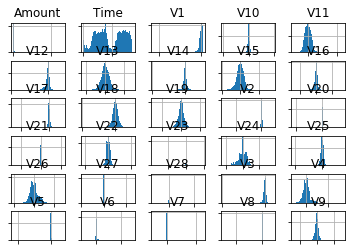

In [48]:
df_ex2 = df_1.drop("Class", axis=1)
# create a histogram plot of each numeric variable
ax = df_ex2.hist(bins=100)
# disable axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
# show the plot
plt.show()

# data preprocessing

#### is there ant missing value in the dataset?

In [53]:
np.any(np.isnan(df_1))
# df_1.isnull().sum() 

False

#### is there any categorical variable? 

In [54]:
df_1.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

#### sepearating features and class 

In [55]:
features = df_1.columns.drop(['Class'])

#### constructing pipeline to pre-process data

In [56]:
pipe_X = Pipeline([
    ("selectattributes", DataFrameSelector(features)),
    ("scaler", RobustScaler())
])

pipe_y = Pipeline([
    ("selectattributes", DataFrameSelector(['Class']))
])

#### selecting random subset of data: 

In [57]:
np.random.seed(42)
subset_size = 20000
selected_indices = np.random.choice(range(nRows), size=subset_size, replace=False)
#selected_indices

df_1_sub = df_1.loc[selected_indices, :]
df_1_sub.columns, df_1_sub.shape

(Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
        'Class'],
       dtype='object'), (20000, 31))

#### finally, preprocessing the data (subset) by applying the pipeline 

In [58]:
""" TODO
Pre-process the data using the pipeliine
"""
X = pipe_X.fit_transform(df_1_sub)
y = pipe_y.fit_transform(df_1_sub).values.ravel()

#### creating train-test split

In [59]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.2)

# SVM model

In [60]:
# from datetime import datetime
# startTime = datetime.now()
######################################

model = SVC(C=10, gamma='scale', kernel='rbf', probability=True)
model.fit(Xtrain, ytrain)

######################################
# print("execution time", datetime.now() - startTime)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

#### test set performance

ROC AUC: 0.9964938642624592
PRC AUC: 0.6091085717483233
F1 Score 0.2500


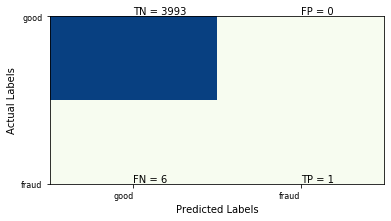

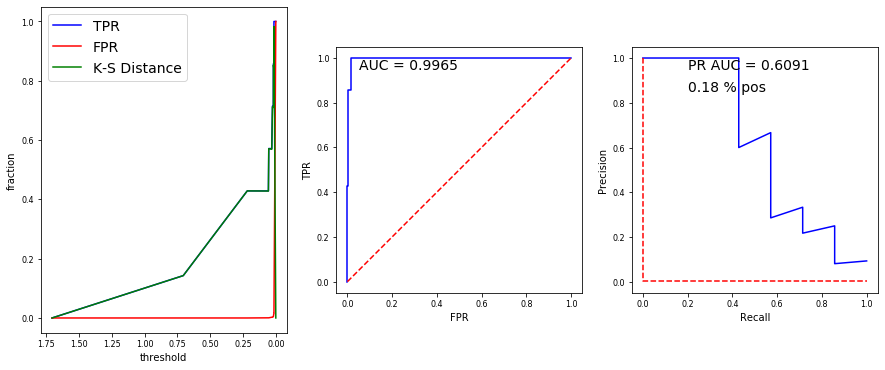

In [61]:
# Confusion matrix
preds_val = model.predict(Xtest)
confusion_mtx_val = confusion_matrix(ytest, preds_val)
#metrics_plots.confusion_mtx_colormap(confusion_mtx_val, targetnames, targetnames)
confusion_mtx_colormap(confusion_mtx_val, targetnames, targetnames)

# Curves
scores_val = model.decision_function(Xtest)
#metrics_plots.ks_roc_prc_plot(ytest, scores_val)

probas_val = model.predict_proba(Xtest)
probas_val = probas_val[:,1]
roc_prc_res_val  = ks_roc_prc_plot(ytest, probas_val)

pss_val = skillScore(ytest, preds_val)
f1_val = f1_score(ytest, preds_val)
#print("PSS: %.4f" % pss_val[0])
print("F1 Score %.4f" % f1_val)

# GridsearchCV

In [62]:
from datetime import datetime
startTime = datetime.now()

######################################

# optimized metric
opt_metric = 'f1'
scoring = {opt_metric:opt_metric}

# experiment hyperparameters
Cs = [.5, 1, 10, 100, 200]
gammas = np.logspace(-4, 0, num=5, endpoint=True, base=5)

nCs = len(Cs)
ngammas = len(gammas)

hyperparams = {'C':Cs, 'gamma':gammas, 'tol':[1e-4],
               'class_weight':[None, 'balanced'], 
               'probability':[True]}

# create the GridSearchCV object
search = GridSearchCV(model, hyperparams, scoring=scoring, refit=opt_metric,
                      cv=5, n_jobs=3, verbose=2, return_train_score=True)
# execute the grid search by calling fit using the training data
search.fit(Xtrain, ytrain)

search

######################################

print("execution time", datetime.now() - startTime)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  5.1min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 34.1min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed: 59.4min finished


execution time 0:59:26.876676


In [60]:
all_results = search.cv_results_
type(all_results)

dict

In [61]:
search.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0016, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.0001, verbose=False)

In [62]:
best_model = search.best_estimator_
best_model.fit(Xtrain, ytrain)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0016, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.0001, verbose=False)

### Test Set Performance

ROC AUC: 0.9938463740116632
PRC AUC: 0.740354210649777
PSS: 0.8569
F1 Score 0.8571


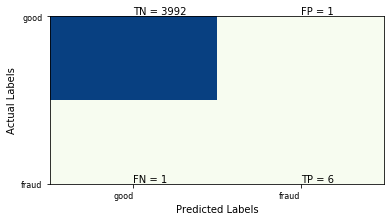

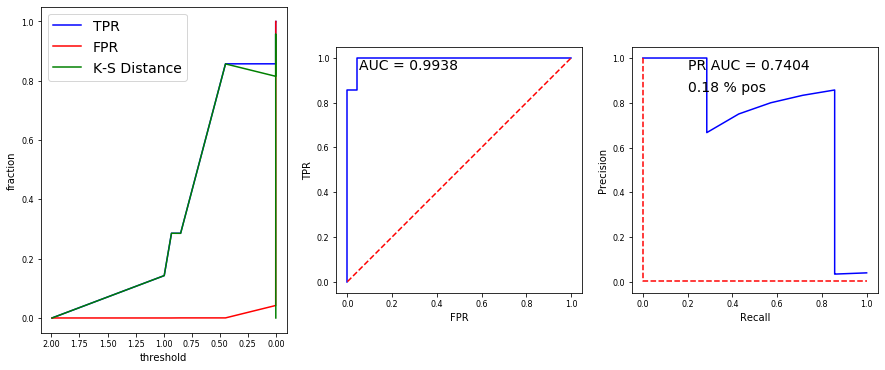

In [64]:
""" TODO
For the best model, display the confusion matrix, KS plot, ROC curve, 
and PR curve for the test set
"""
# TODO: Confustion Matrix
preds_test = best_model.predict(Xtest)
confusion_mtx_test = confusion_matrix(ytest, preds_test)
confusion_mtx_colormap(confusion_mtx_test, targetnames, targetnames)

# TODO: Curves
scores_test = best_model.decision_function(Xtest)
#metrics_plots.ks_roc_prc_plot(ytest, scores_test)

proba_test =  best_model.predict_proba(Xtest)
proba_test = proba_test[:,1]
roc_prc_res_test = ks_roc_prc_plot(ytest, proba_test)

pss_res_test = skillScore(ytest, preds_test)
f1_res_test = f1_score(ytest, preds_test)
print("PSS: %.4f" % pss_res_test[0])
print("F1 Score %.4f" % f1_res_test)